In [1]:
        # !pip install xtb mace-torch nglview ipywidgets
        # !pip install git+https://github.com/imagdau/aseMolec@main

# MACE in Practice II

In this tutorial, you will learn how to improve MLIP models by using iterative training and active learning. We illustrate these training workflows on MACE, but they are broadly applicable to all MLIPs. We will also showcase the state-of-the-art [foundational models](https://matbench-discovery.materialsproject.org/) - the latest development in the field of MLIPs. These models are trained on massive training sets of [inorganic](https://doi.org/10.48550/arXiv.2401.00096) and [organic](https://doi.org/10.48550/arXiv.2312.15211) databases and show a great deal of `out-of-the-box` MD stability in an extensive variety of [applications](https://doi.org/10.48550/arXiv.2401.00096). We will discuss [fine-tunning](https://doi.org/10.48550/arXiv.2405.20217) which is an actively-researched technique to tweak these foundational models to new systems (out of training) and/or new levels of reference theory.

## Learning Objectives for today:

1. **Iterative Training: improving stability and accuracy**
2. **Active learning: committee models**
3. **Foundational models and fine-tuning**

## 1. Iterative Training

### 1.1 MD with a smaller MACE model

The model we trained in our previous tutorial was already stable in MD and quite accurate with little training. This is both because MACE models are smooth and regular (combining lessons from 10-15 years of MLIP development) but also because the task of simulating a single molecule for a few picoseconds is not all that difficult. In general, in real research applications, achieving MD stability and accuracy is not always straightforward from the get-go. Models can be improved through iterative training and active learning which expands the training data to fix errors on the model's potential energy surface. To illustrate these concepts in practice, let's first train a less accurate MACE by reducing the model size and amount of training data:

In [2]:
from ase.io import read, write
db = read('data/solvent_xtb.xyz', ':')
write('data/solvent_xtb_train_20.xyz', db[:23]) #first 20 configs plus the 3 E0s.
write('data/solvent_xtb_test.xyz', db[-50:]) #last 50 configs

!mace_run_train \
    --model="MACE" \
    --num_interactions=2 \
    --num_channels=16 \
    --max_L=0 \
    --correlation=2 \
    --r_max=4.0 \
    --max_ell=2 \
    --name="mace02_com1" \
    --model_dir="MACE_models" \
    --log_dir="MACE_models" \
    --checkpoints_dir="MACE_models" \
    --results_dir="MACE_models" \
    --train_file="data/solvent_xtb_train_20.xyz" \
    --valid_file="data/solvent_xtb_train_50.xyz" \
    --test_file="data/solvent_xtb_test.xyz" \
    --E0s="average" \
    --energy_key="energy_xtb" \
    --forces_key="forces_xtb" \
    --device=cuda \
    --batch_size=10 \
    --max_num_epochs=300 \
    --swa \
    --seed=123

#remove checkpoints since they may cause errors on retraining a model with the same name but a different architecture
import glob
import os
for file in glob.glob("MACE_models/*_run-*.model"):
    os.remove(file)
for file in glob.glob("MACE_models/*.pt"):
    os.remove(file)

/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

Notice, we are getting substantially larger errors than before. Now, let's run some dynamics:

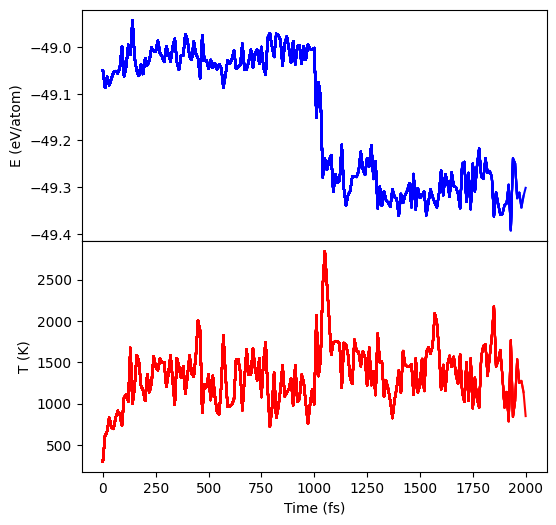

MD finished in 1.93 minutes!


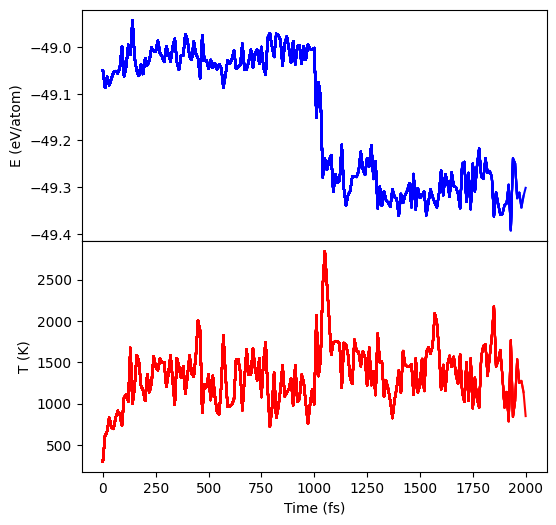

In [3]:
from ase.io import read, write
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution
from aseMolec import extAtoms as ea

import os
import time
import numpy as np
import pylab as pl
from IPython import display
np.random.seed(701) #just making sure the MD failure is reproducible

def simpleMD(init_conf, temp, calc, fname, s, T):
    init_conf.set_calculator(calc)

    #initialize the temperature
    
    MaxwellBoltzmannDistribution(init_conf, temperature_K=300) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn = Langevin(init_conf, 1.0*units.fs, temperature_K=temp, friction=0.1) #drive system to desired temperature

    %matplotlib inline

    time_fs = []
    temperature = []
    energies = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = pl.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.info['energy_mace'] = dyn.atoms.get_potential_energy()
            dyn.atoms.arrays['force_mace'] = dyn.atoms.calc.get_forces()
            dyn.atoms.write(fname, append=True)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

#let us start with a single molecule
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()

#we can use MACE as a calculator in ASE!
from mace.calculators import MACECalculator
mace_calc = MACECalculator(model_paths=['MACE_models/mace02_com1_swa_compiled.model'], device='cuda')

simpleMD(init_conf, temp=1200, calc=mace_calc, fname='moldyn/mace02_md.xyz', s=10, T=2000)

Depending on the random seed for the MD, you may see different things. At first sight, the energy against time doesn't look too bad, although the long time scale wandering of the energy is a little weird. Lets look at the trajectory.

In [21]:
from ase.io import read, write
import nglview as nv

traj = read('moldyn/mace02_md.xyz', ':')
view = nv.show_asetraj(traj)
view._set_size(w='100%', h='500px')
view

NGLWidget(max_frame=200)

If you go to the end of the trajectory, you should find that the bond angles are actually very strange - it looks unphsyical.

### 1.2 Identify the problem and expand training

Something doesn't look right with the hydrogen atoms. Let's re-evaluate the first 100 steps from the trajectory on the reference XTB potential energy surface and then plot it against MACE energy.

In [5]:
from ase.io import read, write
from tqdm import tqdm
from xtb.ase.calculator import XTB
xtb_calc = XTB(method="GFN2-xTB")

#compute true reference XTB values
traj = read('moldyn/mace02_md.xyz', ':')
for at in tqdm(traj[:100]):
    at.calc = None
    at.calc = xtb_calc
    at.info['energy_xtb'] = at.get_potential_energy()
    at.arrays['forces_xtb'] = at.get_forces()
    at.calc = None

write('data/mace02_md_100_xtb.xyz', traj[:100]) #save full result

100% 100/100 [00:00<00:00, 193.04it/s]


Text(0, 0.5, 'Total Energy per Atom (eV)')

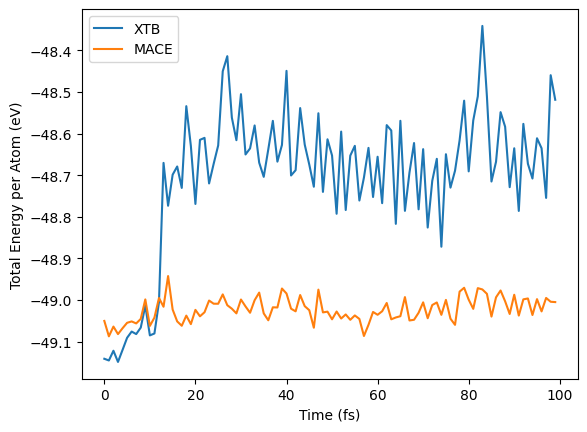

In [6]:
import numpy as np
from aseMolec import extAtoms as ea
from matplotlib import pyplot as plt

traj = read('data/mace02_md_100_xtb.xyz', ':')
plt.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'energy_xtb', peratom=True), label='XTB')
plt.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'energy_mace', peratom=True), label='MACE')
plt.legend()
plt.xlabel('Time (fs)')
plt.ylabel('Total Energy per Atom (eV)')

Indeed, at around frame 40 the XTB energy diverges, because MACE finds an unphysical config. With older potentials, at this point the MD would explode, but because MACE is much smoother the simulation keeps going, albeit generating the wrong dynamics. Let's take three of these failed configs, add them back to the training set and refit a new model. This is called iterative training:
![alt text](figures/iterative_training.png)

In [7]:
db = read('data/solvent_xtb_train_20.xyz', ':')
db += traj[40:100:20] #add three failed configs to the training set
write('data/solvent_xtb_train_23_gen1.xyz', db)

### 1.3 Train a new MACE model and run MD again

In [8]:
!mace_run_train \
    --model="MACE" \
    --num_interactions=2 \
    --num_channels=16 \
    --max_L=0 \
    --correlation=2 \
    --r_max=4.0 \
    --max_ell=2 \
    --name="mace02_com1_gen1" \
    --model_dir="MACE_models" \
    --log_dir="MACE_models" \
    --checkpoints_dir="MACE_models" \
    --results_dir="MACE_models" \
    --train_file="data/solvent_xtb_train_23_gen1.xyz" \
    --valid_file="data/solvent_xtb_train_50.xyz" \
    --test_file="data/solvent_xtb_test.xyz" \
    --E0s="average" \
    --energy_key="energy_xtb" \
    --forces_key="forces_xtb" \
    --device=cuda \
    --batch_size=10 \
    --max_num_epochs=300 \
    --swa \
    --seed=123

#remove checkpoints since they may cause errors on retraining a model with the same name but a different architecture
import glob
import os
for file in glob.glob("MACE_models/*_run-*.model"):
    os.remove(file)
for file in glob.glob("MACE_models/*.pt"):
    os.remove(file)

/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

For some reason the energy error on the training set is now huge - can you work out why this is?

What does this imply about how we do iterative training?

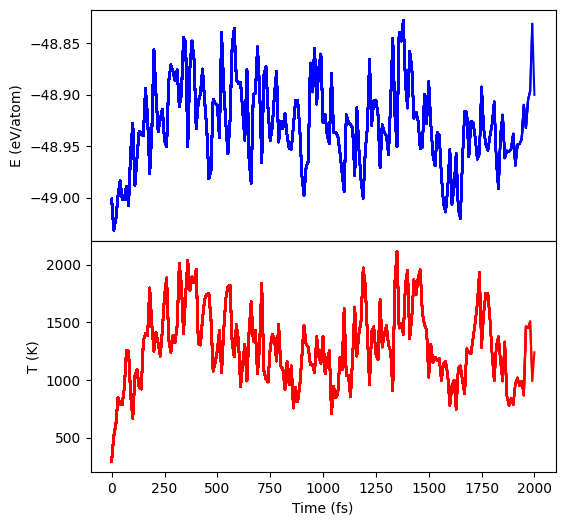

MD finished in 2.05 minutes!


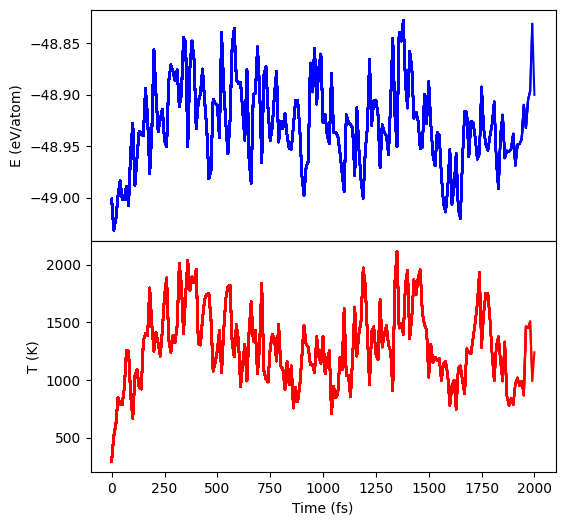

In [9]:
mace_calc = MACECalculator(model_paths=['MACE_models/mace02_com1_gen1_swa_compiled.model'], device='cuda')
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()
simpleMD(init_conf, temp=1200, calc=mace_calc, fname='moldyn/mace02_md_gen1.xyz', s=10, T=2000)

In [10]:
traj = read('moldyn/mace02_md_gen1.xyz', ':')
view = nv.show_asetraj(traj)
view._set_size(w='100%', h='500px')
view

NGLWidget(max_frame=200)

Great! The dynamics is already looking better, however its hard to tell if it is really correct. To do this we cuold look at the radial distribution function compared to a ground truth trajectory, but if the ground truth is too expensive its not so easy.

If we have reason to believe the model is wrong, we could continue the iterative process and gradually improve the potential. This is an arduous process, because we need to carefully investigate the trajectories and decide which configs to add back to training. We could instead automate this protocol by predicting errors on the fly and picking configs which are not well predicted: this is called active learning.

## 2. Active Learning with MACE

### 2.1 Preparing a committee of models

We can compute errors by evaluating the reference energy and forces (in our case XTB) and computing the difference to MACE predictions. In real research applications, this can be very expensive to evaluate depending on the referneece level of theory. Alternatively, we can estimate errors based on a committee of models. Let's train a committee of MACE models by adding some randomness to the optimization process. We can achieve this by changing the `--seed`. We already have a model, we will fit two more, on the same data:

In [11]:
!mace_run_train \
    --model="MACE" \
    --num_interactions=2 \
    --num_channels=16 \
    --max_L=0 \
    --correlation=2 \
    --r_max=4.0 \
    --max_ell=2 \
    --name="mace02_com2" \
    --model_dir="MACE_models" \
    --log_dir="MACE_models" \
    --checkpoints_dir="MACE_models" \
    --results_dir="MACE_models" \
    --train_file="data/solvent_xtb_train_50.xyz" \
    --valid_fraction=0.60 \
    --test_file="data/solvent_xtb_test.xyz" \
    --E0s="average" \
    --energy_key="energy_xtb" \
    --forces_key="forces_xtb" \
    --device=cuda \
    --batch_size=10 \
    --max_num_epochs=300 \
    --swa \
    --seed=345

!mace_run_train \
    --model="MACE" \
    --num_interactions=2 \
    --num_channels=16 \
    --max_L=0 \
    --correlation=2 \
    --r_max=4.0 \
    --max_ell=2 \
    --name="mace02_com3" \
    --model_dir="MACE_models" \
    --log_dir="MACE_models" \
    --checkpoints_dir="MACE_models" \
    --results_dir="MACE_models" \
    --train_file="data/solvent_xtb_train_50.xyz" \
    --valid_fraction=0.60 \
    --test_file="data/solvent_xtb_test.xyz" \
    --E0s="average" \
    --energy_key="energy_xtb" \
    --forces_key="forces_xtb" \
    --device=cuda \
    --batch_size=10 \
    --max_num_epochs=300 \
    --swa \
    --seed=567

#remove checkpoints since they may cause errors on retraining a model with the same name but a different architecture
import glob
import os
for file in glob.glob("MACE_models/*_run-*.model"):
    os.remove(file)
for file in glob.glob("MACE_models/*.pt"):
    os.remove(file)

/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

Perfect, we have two new models. Let's start by testing the commitee on the first 100 frames of the first trajectory we generated. The `MACECalculator` can conveniently take a list of calculators as input and will compute separate energies from each calculator. 

Running committee mace with 3 models
No dtype selected, switching to float64 to match model dtype.


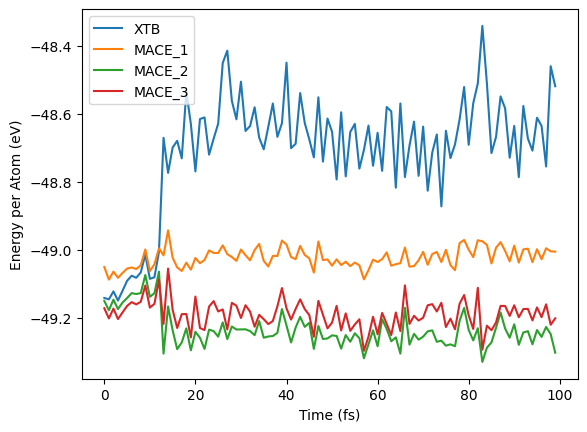

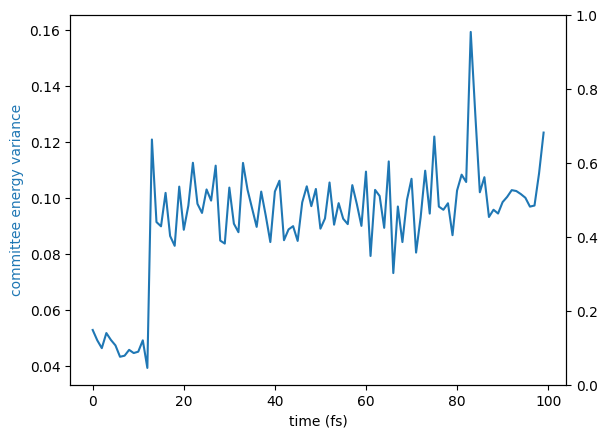

In [12]:
import numpy as np
from ase.io import read
from aseMolec import extAtoms as ea
from matplotlib import pyplot as plt
from mace.calculators import MACECalculator

model_paths = ['MACE_models/mace02_com1_swa_compiled.model',
               'MACE_models/mace02_com2_swa_compiled.model',
               'MACE_models/mace02_com3_swa_compiled.model']
mace_calcs = MACECalculator(model_paths=model_paths, device='cpu')

traj = read('data/mace02_md_100_xtb.xyz', ':')
for at in traj:
    at.calc = mace_calcs
    engs = at.get_potential_energies()
    at.info['energy_mace_1'] = at.info.pop('energy_mace') #rename value obtained with first member of the committee
    at.info['energy_mace_2'] = engs[1]
    at.info['energy_mace_3'] = engs[2]
    at.info['variance'] = np.std(engs)
    at.info['average_mace_energy'] = np.average(engs)
    at.info['true_error'] = np.abs(at.info['average_mace_energy'] - at.info['energy_xtb'])
    
#Let's check the energies of the MACE committee vs XTB energy
plt.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'energy_xtb', peratom=True), label='XTB')
plt.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'energy_mace_1', peratom=True), label='MACE_1')
plt.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'energy_mace_2', peratom=True), label='MACE_2')
plt.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'energy_mace_3', peratom=True), label='MACE_3')
plt.legend()
plt.xlabel('Time (fs)')
plt.ylabel('Energy per Atom (eV)')
plt.show()


#plt.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'variance', peratom=True), label='committee variance')
#plt.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'true_error', peratom=True), label='error w.r.t XTB')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'variance', peratom=True), label='committee variance', color='tab:blue')
#ax2.plot(np.arange(len(traj)), ea.get_prop(traj, 'info', 'true_error', peratom=True), label='error w.r.t XTB', color='tab:orange')

ax1.set_xlabel('time (fs)')
ax1.set_ylabel('committee energy variance', color='tab:blue')
#ax2.set_ylabel('error w.r.t XTB', color='tab:orange')

plt.show()

Notice how the variance (disagreement between models) increases around the same config where the true error with respect to XTB diverges. This is good news because it indicates the variance is a good proxy for true error.

Now we can run dynamics with a commitee of models and monitor the variance in the energy prediction. Because XTB is cheap enough we can also compare that variance with the true error. Do they correlate?

### 2.2 Running MD with the MACE committee

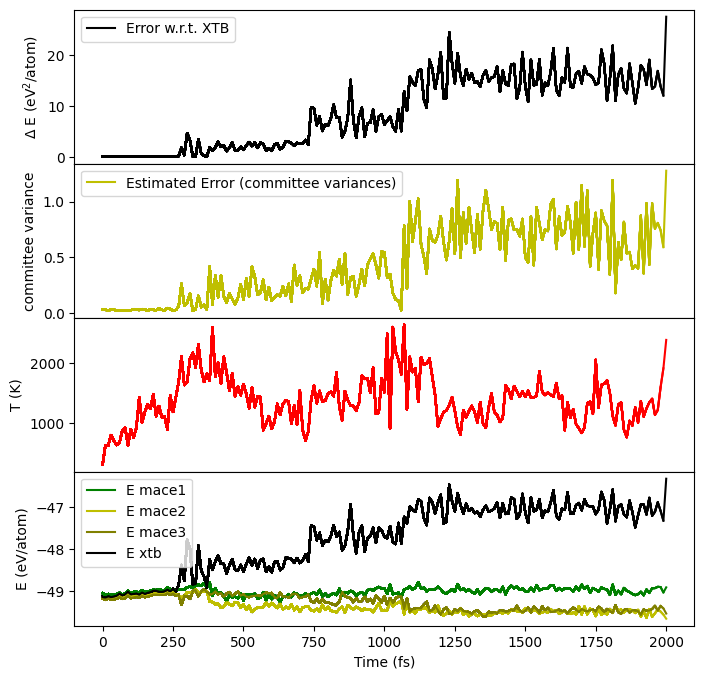

MD finished!


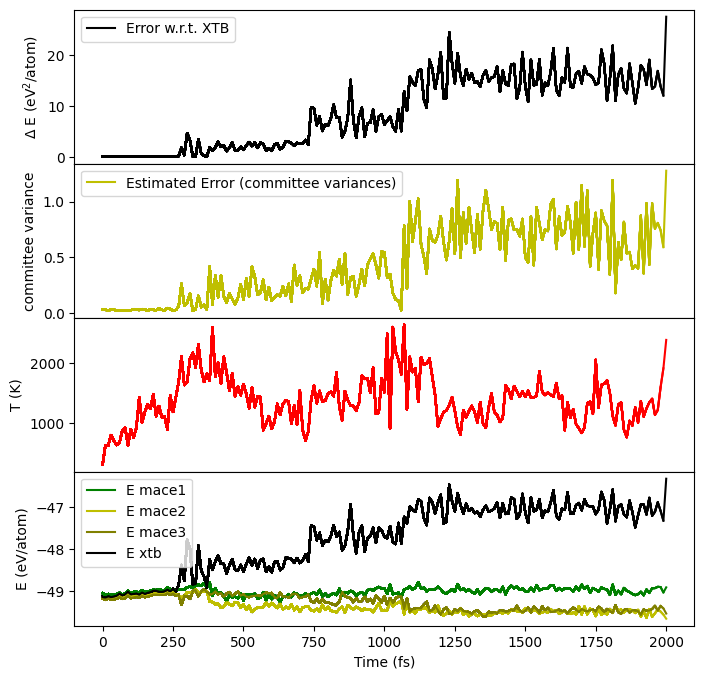

In [13]:
from aseMolec import extAtoms as ea
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution
from ase.io import read, write

import random
import numpy as np
import time
import pylab as pl
from IPython import display

from mace.calculators import MACECalculator
from xtb.ase.calculator import XTB

model_paths = ['MACE_models/mace02_com1_swa_compiled.model',
               'MACE_models/mace02_com2_swa_compiled.model',
               'MACE_models/mace02_com3_swa_compiled.model']
xtb_calc = XTB(method="GFN2-xTB")
mace_calc = MACECalculator(model_paths=model_paths, device='cpu')

init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()
init_conf.calc = mace_calc

#initialize the temperature
np.random.seed(701)
MaxwellBoltzmannDistribution(init_conf, temperature_K=300)
Stationary(init_conf)
ZeroRotation(init_conf)

dyn = Langevin(init_conf, 1*units.fs, temperature_K=1200, friction=0.1)

%matplotlib inline

time_fs = []
temperature = []
energies_1 = []
energies_2 = []
energies_3 = []
variances = []
xtb_energies = []
true_errors = []

!rm -rfv moldyn/mace02_md_committee.xyz
fig, ax = pl.subplots(4, 1, figsize=(8,8), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})


def write_frame():
        at = dyn.atoms.copy()
        at.calc = xtb_calc
        xtb_energy = at.get_potential_energy()

        dyn.atoms.write('moldyn/mace02_md_committee.xyz', append=True, write_results=False)
        time_fs.append(dyn.get_time()/units.fs)
        temperature.append(dyn.atoms.get_temperature())
        energies_1.append(dyn.atoms.calc.results["energies"][0]/len(dyn.atoms))
        energies_2.append(dyn.atoms.calc.results["energies"][1]/len(dyn.atoms))
        energies_3.append(dyn.atoms.calc.results["energies"][2]/len(dyn.atoms))
        variances.append(dyn.atoms.calc.results["energy_var"]/len(dyn.atoms))
        xtb_energies.append(xtb_energy/len(dyn.atoms))
        true_errors.append(np.var([dyn.atoms.calc.results["energy"],xtb_energy])/len(dyn.atoms))

        # plot the true error
        ax[0].plot(np.array(time_fs), np.array(true_errors), color="black")
        ax[0].set_ylabel(r'$\Delta$ E (eV$^2$/atom)')
        ax[0].legend(['Error w.r.t. XTB'], loc='upper left')

        # plot committee variance
        ax[1].plot(np.array(time_fs), np.array(variances), color="y")
        ax[1].set_ylabel(r'committee variance')
        ax[1].legend(['Estimated Error (committee variances)'], loc='upper left')

        # plot the temperature of the system as subplots
        ax[2].plot(np.array(time_fs), temperature, color="r", label='Temperature')
        ax[2].set_ylabel("T (K)")

        ax[3].plot(np.array(time_fs), energies_1, color="g")
        ax[3].plot(np.array(time_fs), energies_2, color="y")
        ax[3].plot(np.array(time_fs), energies_3, color="olive")
        ax[3].plot(np.array(time_fs), xtb_energies, color="black")
        ax[3].set_ylabel("E (eV/atom)")
        ax[3].set_xlabel('Time (fs)')
        ax[3].legend(['E mace1', 'E mace2', 'E mace3', 'E xtb'], loc='upper left')

        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(0.01)

dyn.attach(write_frame, interval=10)
dyn.run(2000)
print("MD finished!")

NOTE: if you get the error `xtb could not evalute the config` that means the dynamics went so crazy and gave such strange configurations, that xtb refused to run! thats to be expected if the model is really bad. Copy some of the code above to have a look at the trajectory if you'd like to see this. 

Closely observe the dynamics. Notice how good the committee error is as a proxy for the true error. In this case the true is cheap to compute, but in most practical applications it won't be. Therefore, we will need to rely on the committee error to identy configurations that should be added back to the training set. This is called active learning:

![alt text](figures/active_learning.png)

### Active learning in practice

The way to use active learning to improve the model is as follows:
1. run dynmics, track the uncertainty.
2. if the uncertainty breaches some predeterined value, stop the simulation and peform the ground truth calculation.
3. and the new config to the dataset, and retrain
4. repeat steps 1-3 until the uncertainty never crosses the threshold

This can be done without human supervision - you can write a program which loops this process. 

As an exercise at the end of the notebook, try writing an active learing loop to gradually grow the dataset and produce a good model, without ever running XTB dynamics. 

## 3 Foundational Models

### 3.1 Molecular Dynamics with MACE-MP-0

Foundation models changed everything. MACE-MP-0 is a model trained on >1 million DFT calcuations, and can run dynamics for the whole periodic table. 

Mace provides a simple interface to load a foundational model, which we can use mow. Check the [documentation](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html) for more details.

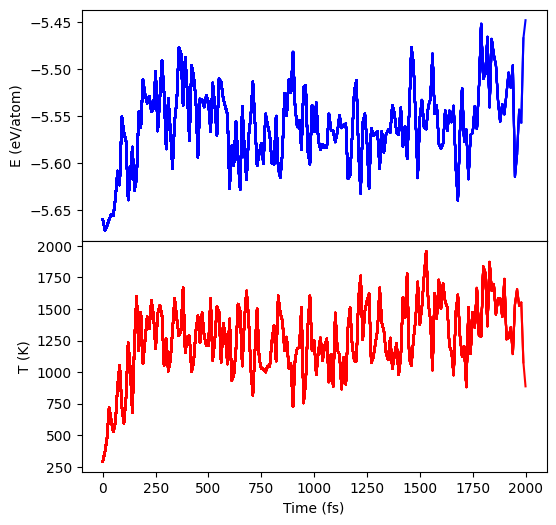

MD finished in 2.22 minutes!


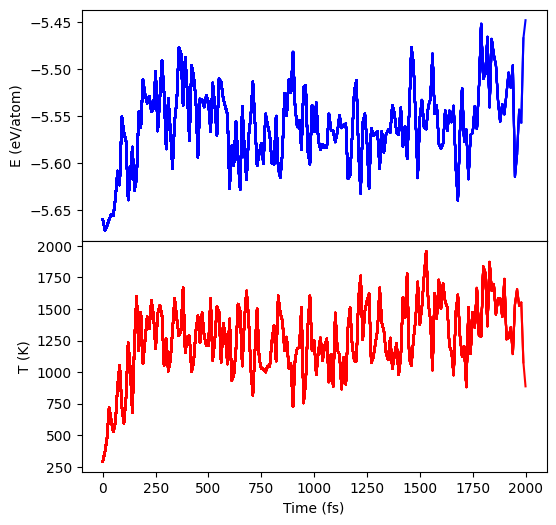

In [14]:
from mace.calculators import mace_mp

macemp = mace_mp(model="small")
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()
simpleMD(init_conf, temp=1200, calc=macemp, fname='moldyn/mace03_md.xyz', s=10, T=2000)

OMG, look at that dynamics! Stable out-of-the-box, sign me up! Let's view the trajectory:

In [15]:
from ase.io import read, write
import nglview as nv

traj = read('moldyn/mace03_md.xyz', ':')
view = nv.show_asetraj(traj)
view._set_size(w='100%', h='500px')
view

NGLWidget(max_frame=200)

### 3.2 Compare to XTB

Let's compute the radial distribution functions of this very stable trajectory and compare them to XTB. Remember MACE-MP was trained on PBE level of theory so we don't necessarily expect them to match:

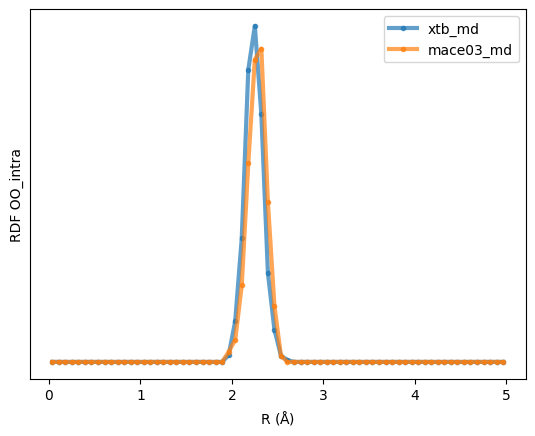

In [16]:
from matplotlib import pyplot as plt
from aseMolec import anaAtoms as aa

tag = 'OO_intra' #choose one of 'HH_intra', 'HC_intra', 'HO_intra', 'CC_intra', 'CO_intra', 'OO_intra'

for f in ['xtb_md', 'mace03_md']:
    traj = read('moldyn/'+f+'.xyz', '50:') #ignore first 50 frames
    for at in traj:
        at.pbc = True #create a fake box for rdf compatibility
        at.cell = [100,100,100]
    rdf = aa.compute_rdfs_traj_avg(traj, rmax=5, nbins=70) #aseMolec provides functionality to compute RDFs
    plt.plot(rdf[1], rdf[0][tag], '.-', label=f, alpha=0.7, linewidth=3)

plt.legend();
plt.yticks([]);
plt.xlabel(r'R ($\rm \AA$)');
plt.ylabel('RDF '+tag);

Notice there's a slight shift in the O-O RDF peak. This is likely due to the different level of reference theory. Can we fix by fine tuning MACE-MP-0?

Depending on your application, the PBE reference using in MACE-MP-0 may not be appropriate. It is probably better than XTB, but thats because for this notebook we are using XTB since it is extremely fast, so we can check the model's true error very easily. 

In practice, you might want to run dynamics of this small molecule at the MP2 or coupled cluster level (which is the 'gold standard' of molecular quantum chemistry). In that case, you would want to finetune MACE-MP-0 onto a small amount of very expensive couple cluster data.

### 3.3 Fine tune MACE-MP to XTB

In [17]:
!mace_run_train \
    --name="finetuned_MACE" \
    --foundation_model="small" \
    --train_file="data/solvent_xtb_train_50.xyz" \
    --valid_fraction=0.60 \
    --test_file="data/solvent_xtb_test.xyz" \
    --energy_weight=1.0 \
    --forces_weight=1.0 \
    --E0s="average" \
    --energy_key="energy_xtb" \
    --forces_key="forces_xtb" \
    --lr=0.01 \
    --scaling="rms_forces_scaling" \
    --batch_size=10 \
    --max_num_epochs=50 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --default_dtype="float64" \
    --device=cuda \
    --seed=3

/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

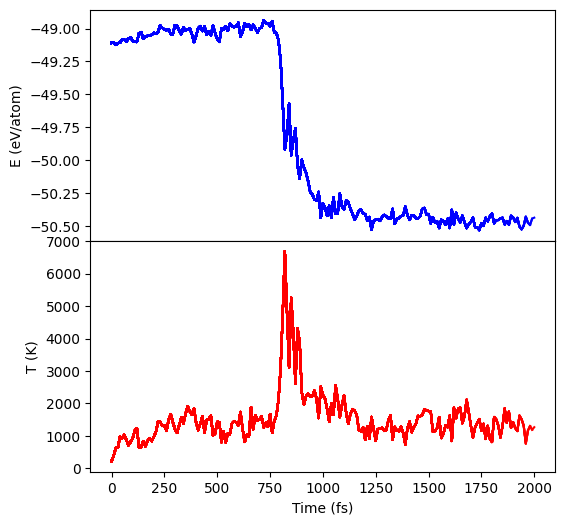

MD finished in 2.17 minutes!


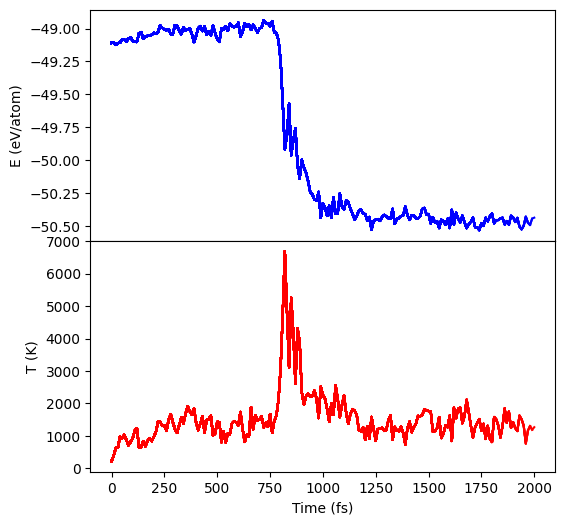

In [18]:
mace_calc = MACECalculator(model_paths=['finetuned_MACE_compiled.model'], device='cuda')

init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()
simpleMD(init_conf, temp=1200, calc=mace_calc, fname='moldyn/mace_finetuned_md.xyz', s=10, T=2000)

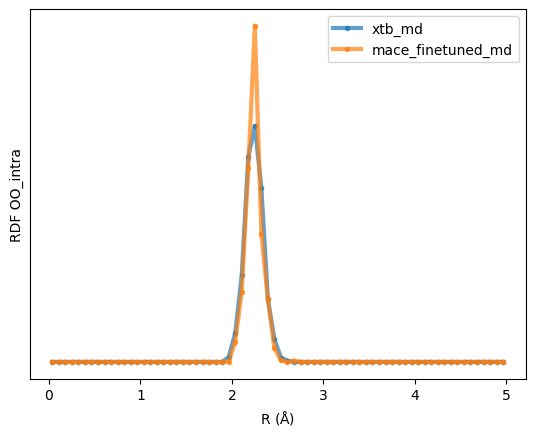

In [19]:
from matplotlib import pyplot as plt
from aseMolec import anaAtoms as aa

tag = 'OO_intra' # 'OO_intra' #choose one of 'HH_intra', 'HC_intra', 'HO_intra', 'CC_intra', 'CO_intra', 'OO_intra'

for f in ['xtb_md', 'mace_finetuned_md']:
    traj = read('moldyn/'+f+'.xyz', '50:') #ignore first 50 frames
    for at in traj:
        at.pbc = True #create a fake box for rdf compatibility
        at.cell = [100,100,100]
    rdf = aa.compute_rdfs_traj_avg(traj, rmax=5, nbins=70) #aseMolec provides functionality to compute RDFs
    plt.plot(rdf[1], rdf[0][tag], '.-', label=f, alpha=0.7, linewidth=3)

plt.legend();
plt.yticks([]);
plt.xlabel(r'R ($\rm \AA$)');
plt.ylabel('RDF '+tag);

In [20]:
from ase.io import read, write
import nglview as nv

traj = read('moldyn/mace_finetuned_md.xyz', ':')
view = nv.show_asetraj(traj)
view._set_size(w='100%', h='500px')
view

NGLWidget(max_frame=200)

What are the results - does it work?

Consider comparing more than one of the rdfs, and looking at how the MP0-model did (as we saw above) vs the finetuned version.